# Contents
1. [Setup](#Setup)
2. [Data Validation](#Data-Validation)
3. [EDA](#EDA)

# Setup

#### Import Libraries

In [22]:
import requests
import pandas as pd
from datetime import datetime

import tweepy
import yaml

import os
os.chdir('/Users/ashrithreddy/Documents/bitcoin_utils/')

#### Import API keys


In [23]:
with open("config/config.yaml", "r") as file:
    config = yaml.safe_load(file)

cryptocompare_config = config['cryptocompare']

# Cryptocompare API keys
api_key = cryptocompare_config['api_key']
api_key

'8379999ad12062e9b27e6e4e374363befe1f8e1917f52e7814f16e78dd7fa54b'

#### Reading Data

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

url = "https://min-api.cryptocompare.com/data/v2/histoday"

# Starting timestamp (earliest BTC data available)
start_date = datetime(2013, 4, 28)  # Earliest available date
end_date = datetime.now()            # Retrieve data up to today

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

# Loop through dates in 365-day chunks
while start_date < end_date:
    # Set end date for this chunk to be 365 days from start_date or the actual end_date
    chunk_end_date = min(start_date + timedelta(days=364), end_date)
    to_ts = int(chunk_end_date.timestamp())
    
    # Set up the parameters for the API request
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 365,
        'toTs': to_ts,
        'api_key': api_key
    }

    # Request the data for the chunk
    response = requests.get(url, params=params)
    data = response.json()

    # Check if the response was successful
    if data.get('Response') == 'Success':
        # Access the nested data under 'Data' > 'Data'
        daily_data = data['Data']['Data']
        
        # Extract date and all price-related fields
        dates = [datetime.fromtimestamp(item['time']).date() for item in daily_data]
        open_prices = [item['open'] for item in daily_data]
        high_prices = [item['high'] for item in daily_data]
        low_prices = [item['low'] for item in daily_data]
        close_prices = [item['close'] for item in daily_data]
        volume_from = [item['volumefrom'] for item in daily_data]
        volume_to = [item['volumeto'] for item in daily_data]
        
        # Create DataFrame for this chunk
        chunk_df = pd.DataFrame({
            'Date': pd.to_datetime(dates),
            'Open': open_prices,
            'High': high_prices,
            'Low': low_prices,
            'Close': close_prices,
            'Volume_From': volume_from,
            'Volume_To': volume_to
        })
        
        # Append chunk data to the main DataFrame
        all_data = pd.concat([all_data, chunk_df], ignore_index=True)
        print(f"Data chunk from {start_date.date()} to {chunk_end_date.date()} retrieved successfully.")
    else:
        print("Error retrieving data:", data.get('Message', 'An unknown error occurred'))
    
    # Move start_date to the next day after the current chunk_end_date
    start_date = chunk_end_date + timedelta(days=1)

# Now all_data contains the full dataset; let's organize it by calendar year
all_data['Year'] = all_data['Date'].dt.year

# Save data for each calendar year in separate files
for year, year_df in all_data.groupby('Year'):
    # Filter data to the specific calendar year and save to CSV
    year_df.to_csv(f'data/BTC_Price_{year}.csv', index=False)
    print(f"Data for {year} saved successfully.")

# Display the first and last few rows of the complete dataset for verification
print(all_data.head())
print(all_data.tail())

[Back to the top](#Contents)

# Data Validation

In [53]:
import pandas as pd
import glob

# Path to the folder containing the CSV files
file_path = 'data/BTC_Price_*.csv'

# Use glob to list all matching files
all_files = glob.glob(file_path)

# Read each CSV file and concatenate them into a single DataFrame
btc_prices = pd.concat([pd.read_csv(file) for file in all_files], ignore_index=True)

# Display the first few rows and basic info for verification
print(btc_prices.head())

         Date     Open     High      Low    Close  Volume_From     Volume_To  \
0  2020-01-01  7189.94  7224.84  6945.83  6965.72     26531.32  1.873940e+08   
1  2020-01-02  6965.72  7407.11  6882.62  7339.70     51975.01  3.766904e+08   
2  2020-01-03  7339.70  7405.75  7278.60  7357.50     22083.57  1.621069e+08   
3  2020-01-04  7357.50  7501.42  7330.07  7359.96     24084.13  1.791477e+08   
4  2020-01-05  7359.96  7799.63  7355.11  7762.69     46443.66  3.522862e+08   

   Year  
0  2020  
1  2020  
2  2020  
3  2020  
4  2020  


- Missing values

In [54]:
btc_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4392 non-null   object 
 1   Open         4392 non-null   float64
 2   High         4392 non-null   float64
 3   Low          4392 non-null   float64
 4   Close        4392 non-null   float64
 5   Volume_From  4392 non-null   float64
 6   Volume_To    4392 non-null   float64
 7   Year         4392 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 274.6+ KB


- Continuity

In [51]:
import pandas as pd

# Ensure the 'Date' column is in datetime format
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# Group by year and calculate the number of days, min date, and max date for each year
yearly_summary = btc_prices.groupby(btc_prices['Date'].dt.year).agg(
    Days_Count=('Date', 'nunique'),
    Min_Date=('Date', 'min'),
    Max_Date=('Date', 'max')
).reset_index().rename(columns={'Date': 'Year'})

# Display the summary
print(yearly_summary)

    Year  Days_Count   Min_Date   Max_Date
0   2013         250 2013-04-26 2013-12-31
1   2014         365 2014-01-01 2014-12-31
2   2015         365 2015-01-01 2015-12-31
3   2016         366 2016-01-01 2016-12-31
4   2017         365 2017-01-01 2017-12-31
5   2018         365 2018-01-01 2018-12-31
6   2019         365 2019-01-01 2019-12-31
7   2020         366 2020-01-01 2020-12-31
8   2021         365 2021-01-01 2021-12-31
9   2022         365 2022-01-01 2022-12-31
10  2023         365 2023-01-01 2023-12-31
11  2024         300 2024-01-01 2024-10-26


[Back to the top](#Contents)

# EDA

#### Line Chart

In [60]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Ensure the 'Date' column is in datetime format
# btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# # Sort by date to ensure the line chart is chronological
# btc_prices = btc_prices.sort_values('Date')

# # Plotting the line chart
# plt.figure(figsize=(12, 6))
# plt.plot(btc_prices['Date'], btc_prices['Close'], label='Close Price', linewidth=1)

# # Adding labels and title
# plt.xlabel('Date')
# plt.ylabel('BTC Price (USD)')
# plt.title('Bitcoin Closing Prices Over Time')
# plt.legend()
# plt.grid(True)

# # Display the plot
# plt.show()


In [61]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd

# # Ensure the 'Date' column is in datetime format
# btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# # Sort by date to ensure the line chart is chronological
# btc_prices = btc_prices.sort_values('Date')

# # Plotting the line chart with enhanced aesthetics
# plt.figure(figsize=(14, 7))
# plt.plot(btc_prices['Date'], btc_prices['Close'], label='Close Price', color='royalblue', linewidth=1.5)

# # Improving aesthetics
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('BTC Price (USD)', fontsize=14)
# plt.title('Bitcoin Closing Prices Over Time', fontsize=16, fontweight='bold')
# plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)

# # Formatting the Y-axis with thousands separators
# plt.ticklabel_format(style='plain', axis='y')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

# # Formatting the x-axis to show major ticks yearly and minor ticks monthly
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Display the plot
# plt.show()


In [62]:
# import plotly.graph_objects as go
# import pandas as pd

# # Ensure 'Date' column is in datetime format
# btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# # Create an interactive line chart with Plotly
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=btc_prices['Date'], 
#     y=btc_prices['Close'],
#     mode='lines',
#     name='Close Price',
#     line=dict(color='royalblue', width=1.5),
#     hovertemplate='Date: %{x}<br>Price: $%{y:,.2f}<extra></extra>'
# ))

# # Customize layout
# fig.update_layout(
#     title='Bitcoin Closing Prices Over Time',
#     xaxis_title='Date',
#     yaxis_title='BTC Price (USD)',
#     template='plotly_white',
#     title_x=0.5,
#     font=dict(size=14),
#     hovermode="x unified"
# )

# # Update x-axis for yearly ticks
# fig.update_xaxes(
#     tickformat="%Y",
#     tickangle=45,
#     showgrid=True,
#     gridcolor="LightGrey"
# )

# # Update y-axis to show thousands separator
# fig.update_yaxes(tickprefix="$", showgrid=True, gridcolor="LightGrey")

# # Show the interactive plot
# fig.show()


In [63]:
# import plotly.graph_objects as go
# import pandas as pd

# # Ensure 'Date' column is in datetime format
# btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# # Create an interactive line chart with Plotly
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=btc_prices['Date'], 
#     y=btc_prices['Close'],
#     mode='lines',
#     name='BTC Close Price',  # This label will appear in the legend
#     line=dict(color='royalblue', width=1.5),
#     hovertemplate='Date: %{x}<br>Price: $%{y:,.2f}<extra></extra>'
# ))

# # Customize layout
# fig.update_layout(
#     title='BTC Price',
#     xaxis_title='Date',
#     yaxis_title='BTC Price (USD)',
#     template='plotly_white',
#     title_x=0.5,
#     font=dict(size=14),
#     hovermode="x unified",
#     height=600,  # Make the plot taller
#     legend=dict(
#         title="Legend",
#         orientation="h",
#         yanchor="bottom",
#         y=1.02,
#         xanchor="center",
#         x=0.5
#     )
# )

# # Update x-axis for yearly ticks
# fig.update_xaxes(
#     tickformat="%Y",
#     tickangle=45,
#     showgrid=True,
#     gridcolor="LightGrey"
# )

# # Update y-axis to show thousands separator
# fig.update_yaxes(tickprefix="$", showgrid=True, gridcolor="LightGrey")

# # Show the interactive plot
# fig.show()


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



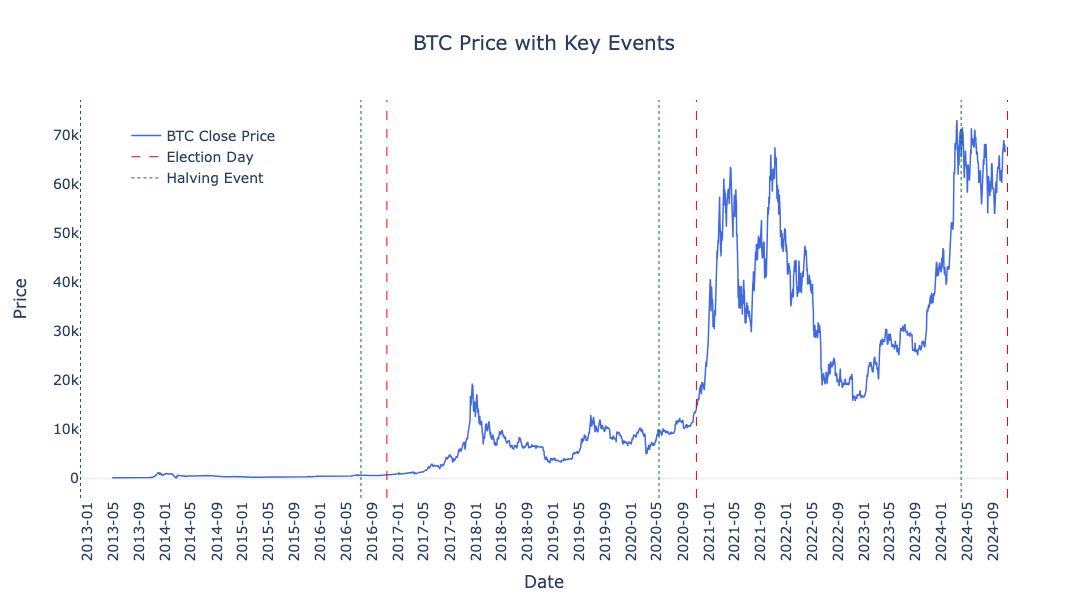

In [77]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

# Ensure 'Date' column is in datetime format
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# Create an interactive line chart with Plotly
fig = go.Figure()

# Plot the BTC price line
fig.add_trace(go.Scatter(
    x=btc_prices['Date'], 
    y=btc_prices['Close'],
    mode='lines',
    name='BTC Close Price',
    line=dict(color='royalblue', width=1.5),
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: $%{y:,.2f}<extra></extra>',
))

# Add a hidden scatter trace to create the "Election Day" legend entry
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    name='Election Day',
    line=dict(color='red', width=1, dash='dash')
))

# Add a hidden scatter trace to create the "Halving Event" legend entry
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    name='Halving Event',
    line=dict(color='green', width=1, dash='dot')
))

# Add vertical lines for Election Days using `add_vline`
election_dates = [datetime(2016, 11, 8), datetime(2020, 11, 3), datetime(2024, 11, 5)]
for date in election_dates:
    fig.add_vline(
        x=date,
        line=dict(color="red", width=1, dash="dash")
    )

# Add vertical lines for Bitcoin Halving Events using `add_vline`
halving_dates = [datetime(2012, 11, 28), datetime(2016, 7, 9), datetime(2020, 5, 11), datetime(2024, 4, 1)]
for date in halving_dates:
    fig.add_vline(
        x=date,
        line=dict(color="green", width=1, dash="dot")
    )

# Customize layout
fig.update_layout(
    title='BTC Price with Key Events',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    title_x=0.5,
    font=dict(size=14),
    hovermode="x unified",
    height=600,
    legend=dict(
        title="",
        orientation="v",
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.05
    )
)

# Update x-axis for more frequent ticks (every 4 months) and rotate labels
fig.update_xaxes(
    dtick="M4",
    tickformat="%Y-%m",
    tickangle=270,
    showgrid=False
)

# Update y-axis to remove gridlines
fig.update_yaxes(showgrid=False)

# Show the interactive plot
fig.show()


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



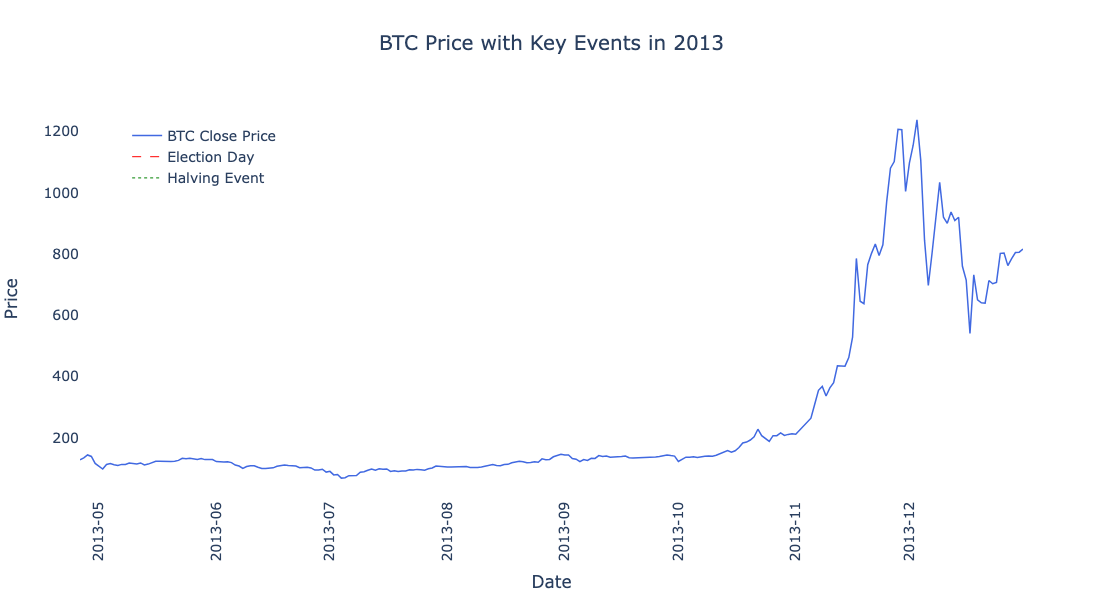

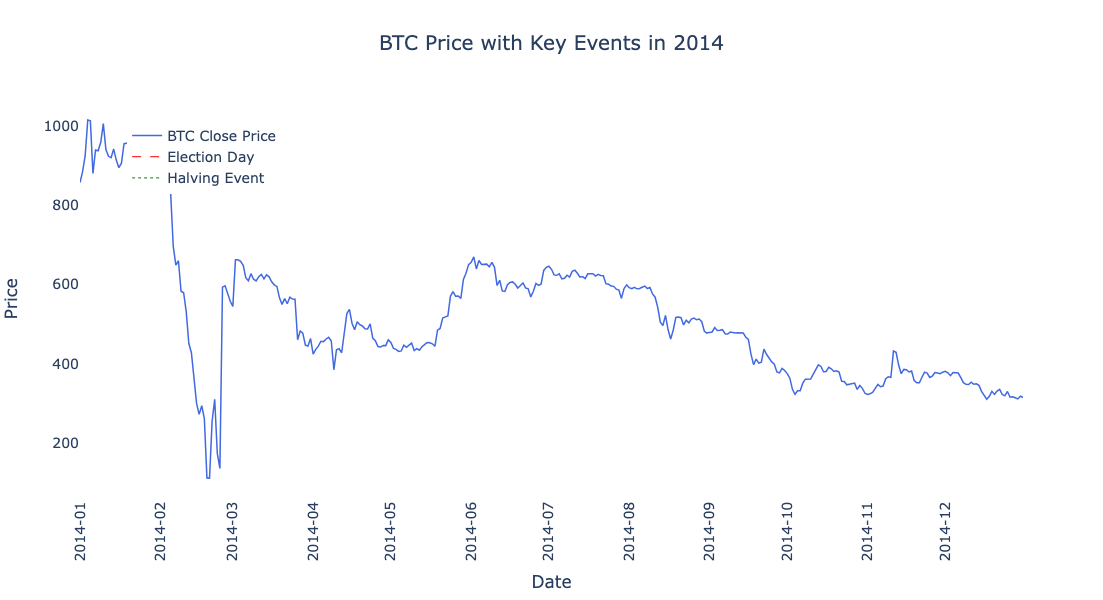

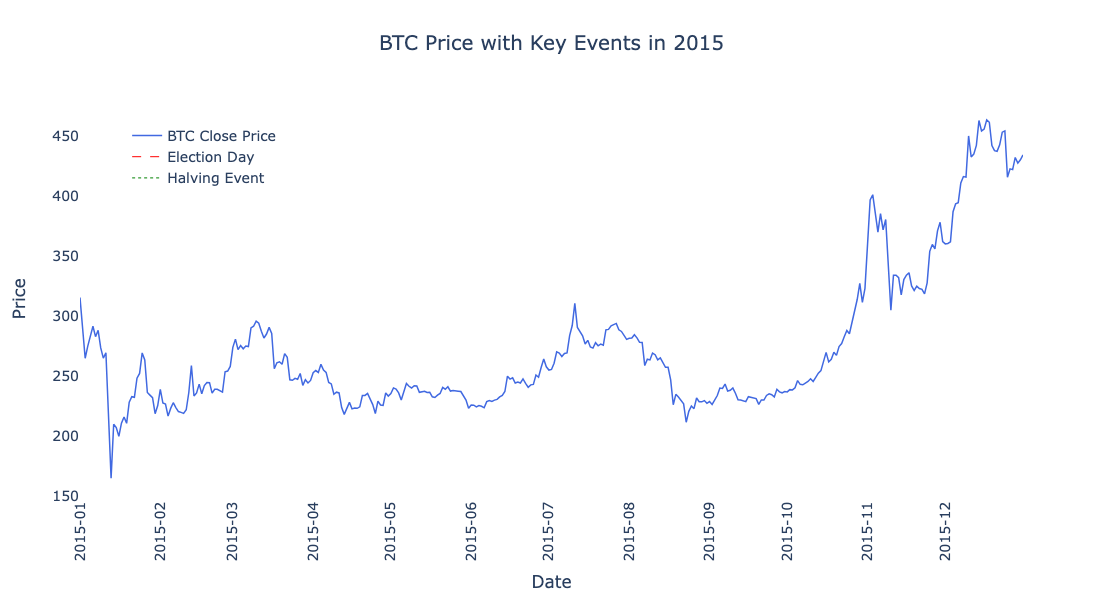

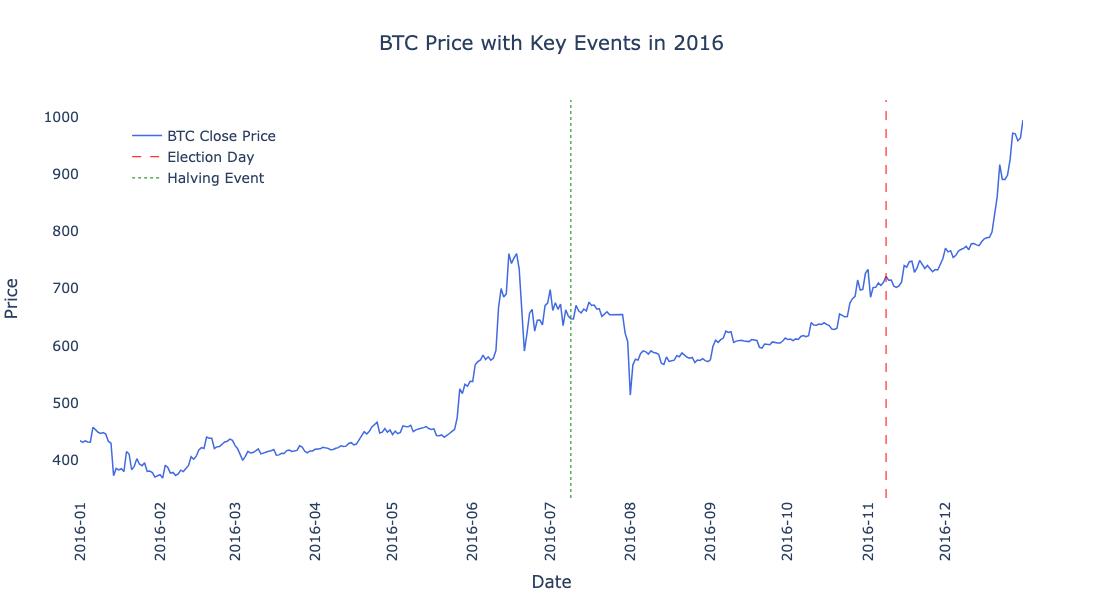

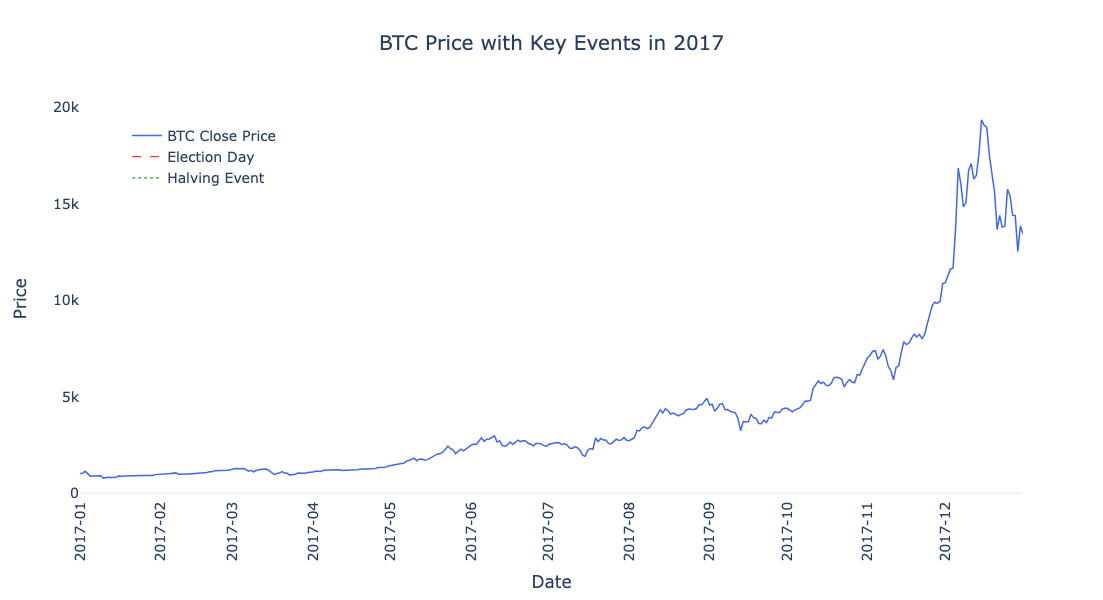

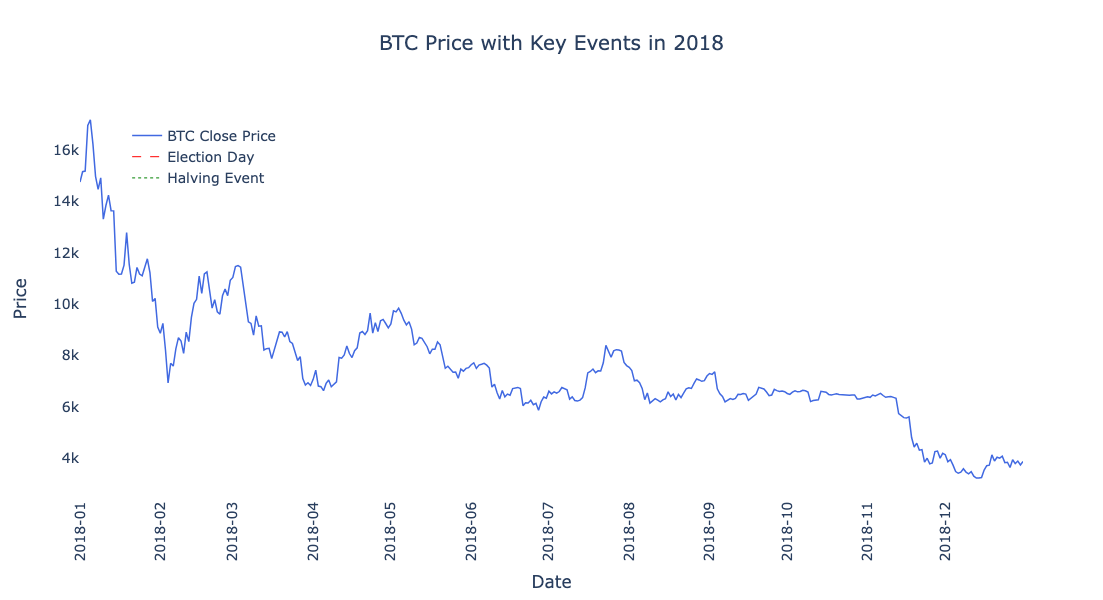

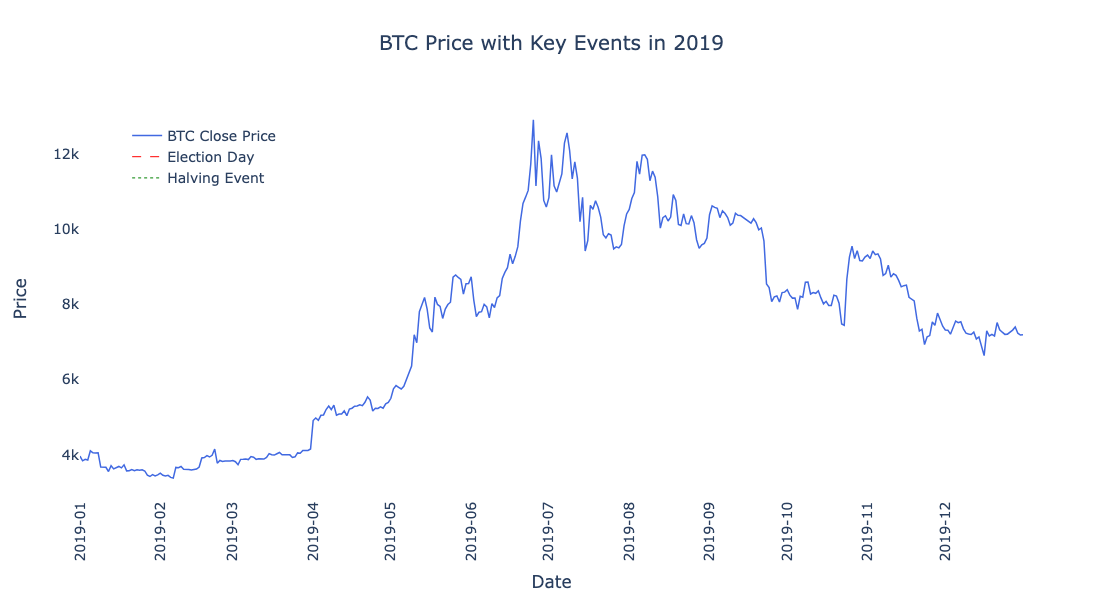

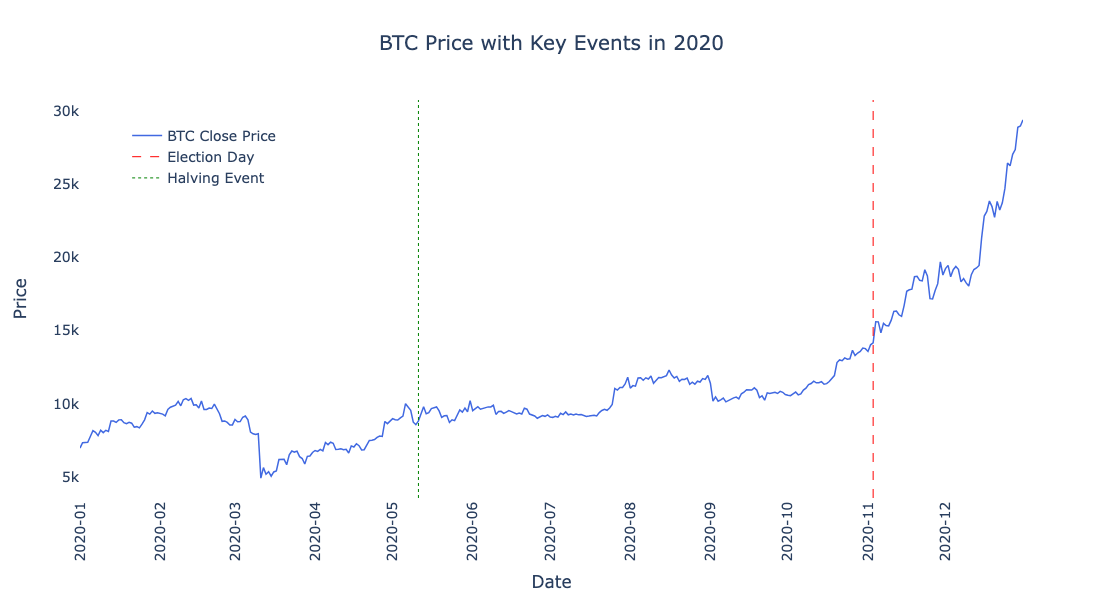

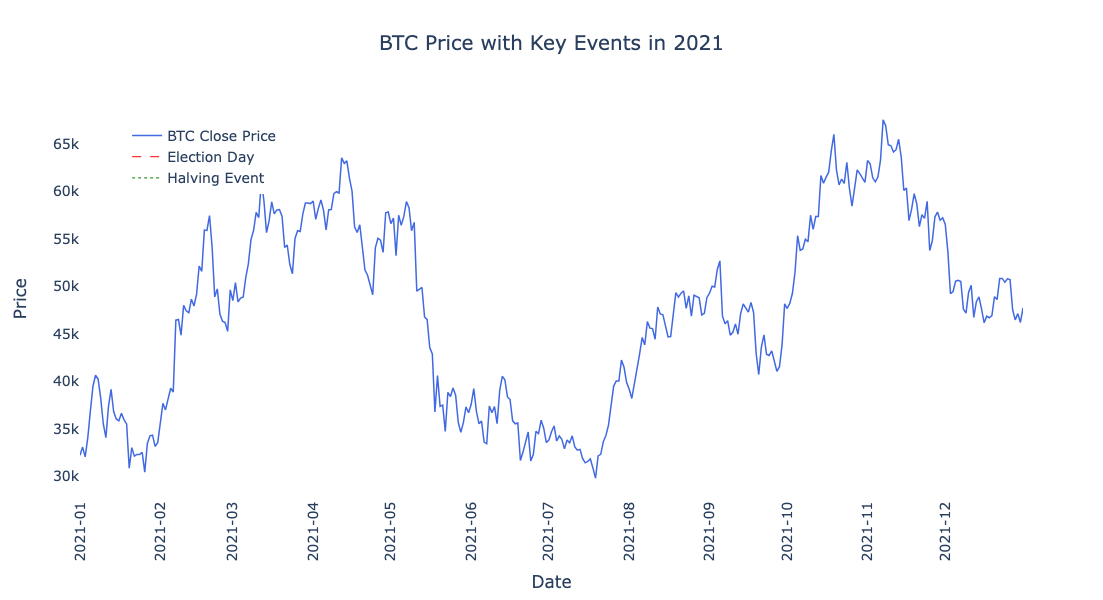

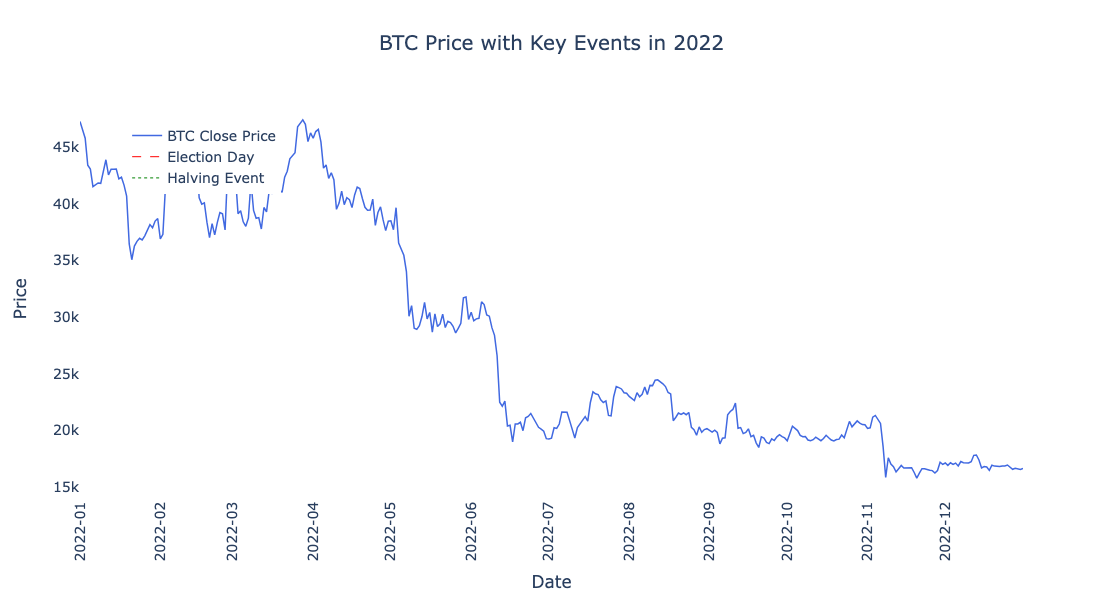

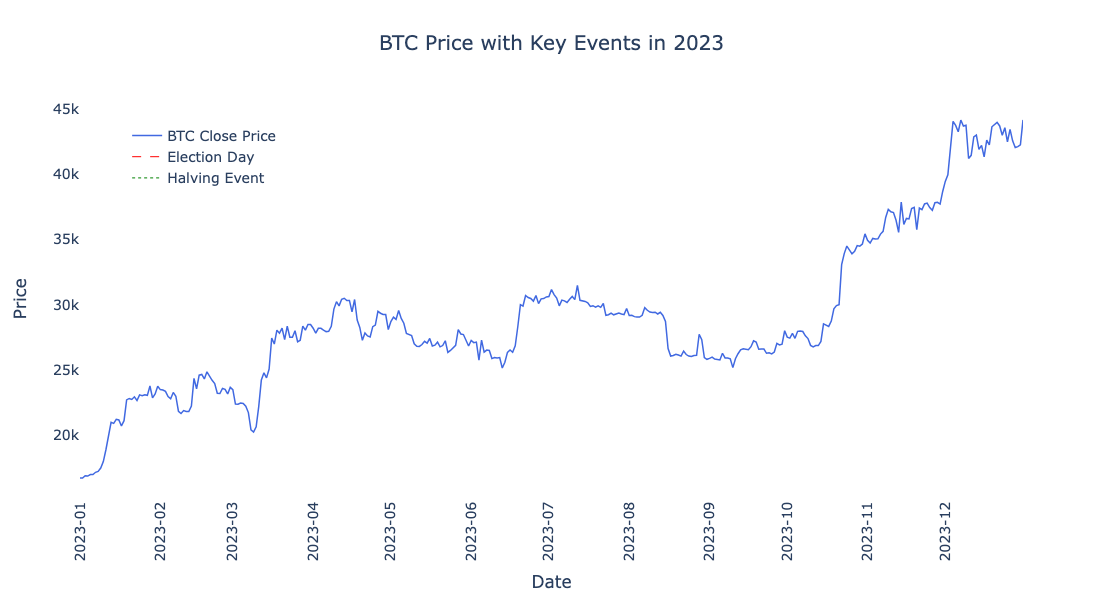

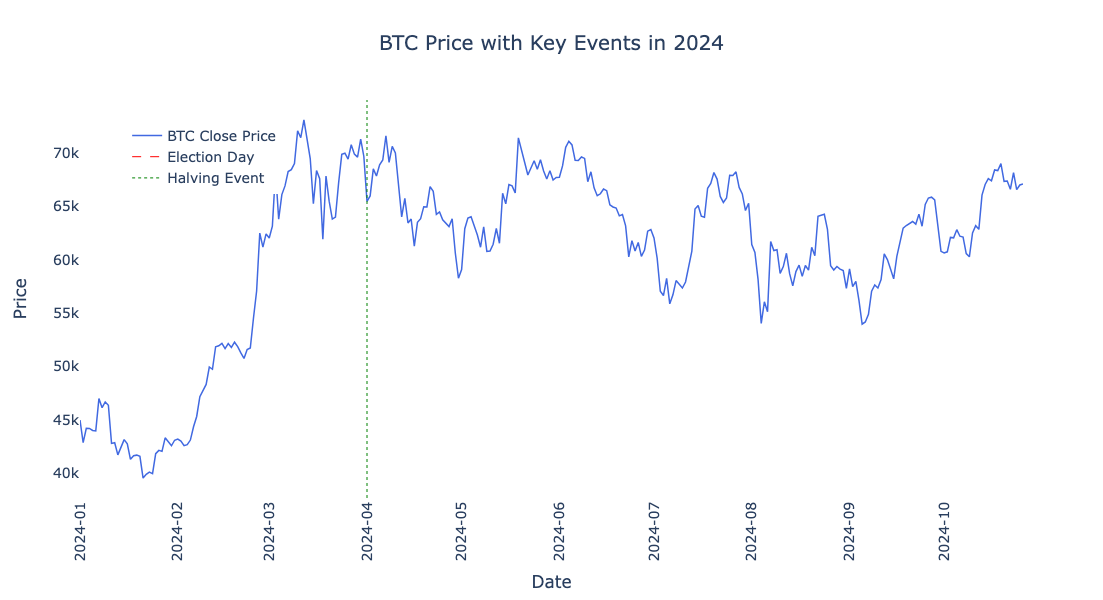

In [86]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

# Ensure 'Date' column is in datetime format
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# Define the year range for which to generate plots
start_year = 2013
end_year = 2024

# Loop through each year in the specified range
for year in range(start_year, end_year + 1):
    # Filter data for the current year
    min_date = datetime(year, 1, 1)
    max_date = datetime(year, 12, 31)
    filtered_data = btc_prices[(btc_prices['Date'] >= min_date) & (btc_prices['Date'] <= max_date)]
    
    # Set x-axis range dynamically based on filtered data
    x_axis_range = [filtered_data['Date'].min(), filtered_data['Date'].max()] if not filtered_data.empty else None
    
    # Create a new figure for the current year
    fig = go.Figure()

    # Plot the BTC price line within the filtered date range
    fig.add_trace(go.Scatter(
        x=filtered_data['Date'], 
        y=filtered_data['Close'],
        mode='lines',
        name='BTC Close Price',
        line=dict(color='royalblue', width=1.5),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: $%{y:,.2f}<extra></extra>',
    ))

    # Add a hidden scatter trace to create the "Election Day" legend entry
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        name='Election Day',
        line=dict(color='red', width=1, dash='dash')
    ))

    # Add a hidden scatter trace to create the "Halving Event" legend entry
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        name='Halving Event',
        line=dict(color='green', width=1, dash='dot')
    ))

    # Add vertical lines for Election Days in the current year using `add_vline`
    election_dates = [datetime(2016, 11, 8), datetime(2020, 11, 3), datetime(2024, 11, 5)]
    for date in election_dates:
        if min_date <= date <= max_date:  # Only add if within the filter range
            fig.add_vline(
                x=date,
                line=dict(color="red", width=1, dash="dash")
            )

    # Add vertical lines for Bitcoin Halving Events in the current year using `add_vline`
    halving_dates = [datetime(2012, 11, 28), datetime(2016, 7, 9), datetime(2020, 5, 11), datetime(2024, 4, 1)]
    for date in halving_dates:
        if min_date <= date <= max_date:  # Only add if within the filter range
            fig.add_vline(
                x=date,
                line=dict(color="green", width=1, dash="dot")
            )

    # Customize layout
    fig.update_layout(
        title=f'BTC Price with Key Events in {year}',
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white',
        title_x=0.5,
        font=dict(size=14),
        hovermode="x unified",
        height=600,
        legend=dict(
            title="",
            orientation="v",
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.05
        )
    )

    # Update x-axis for more frequent ticks and rotate labels
    fig.update_xaxes(
        dtick="M1",           # Set monthly ticks for each year plot
        tickformat="%Y-%m",
        tickangle=270,
        showgrid=False,
        range=x_axis_range  # Dynamically set the x-axis range based on filtered data
    )

    # Update y-axis to remove gridlines
    fig.update_yaxes(showgrid=False)

    # Show the plot for the current year
    fig.show()  # Display in notebook


- Log Scale

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



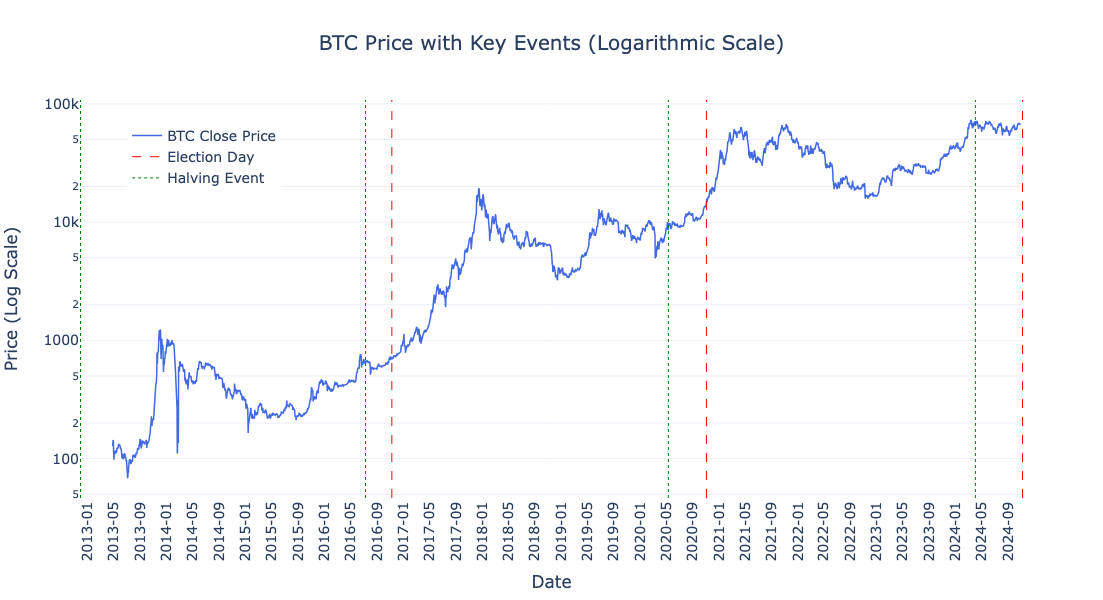

In [88]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

# Ensure 'Date' column is in datetime format
btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])

# Create an interactive line chart with Plotly
fig = go.Figure()

# Plot the BTC price line with a logarithmic y-axis
fig.add_trace(go.Scatter(
    x=btc_prices['Date'], 
    y=btc_prices['Close'],
    mode='lines',
    name='BTC Close Price',
    line=dict(color='royalblue', width=1.5),
    hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: $%{y:,.2f}<extra></extra>',
))

# Add a hidden scatter trace to create the "Election Day" legend entry
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    name='Election Day',
    line=dict(color='red', width=1, dash='dash')
))

# Add a hidden scatter trace to create the "Halving Event" legend entry
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='lines',
    name='Halving Event',
    line=dict(color='green', width=1, dash='dot')
))

# Add vertical lines for Election Days using `add_vline`
election_dates = [datetime(2016, 11, 8), datetime(2020, 11, 3), datetime(2024, 11, 5)]
for date in election_dates:
    fig.add_vline(
        x=date,
        line=dict(color="red", width=1, dash="dash")
    )

# Add vertical lines for Bitcoin Halving Events using `add_vline`
halving_dates = [datetime(2012, 11, 28), datetime(2016, 7, 9), datetime(2020, 5, 11), datetime(2024, 4, 1)]
for date in halving_dates:
    fig.add_vline(
        x=date,
        line=dict(color="green", width=1, dash="dot")
    )

# Customize layout
fig.update_layout(
    title='BTC Price with Key Events (Logarithmic Scale)',
    xaxis_title='Date',
    yaxis_title='Price (Log Scale)',
    template='plotly_white',
    title_x=0.5,
    font=dict(size=14),
    hovermode="x unified",
    height=600,
    legend=dict(
        title="",
        orientation="v",
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.05
    )
)

# Update x-axis for more frequent ticks (every 4 months) and rotate labels
fig.update_xaxes(
    dtick="M4",
    tickformat="%Y-%m",
    tickangle=270,
    showgrid=False
)

# Update y-axis to logarithmic scale and remove gridlines
fig.update_yaxes(type="log", showgrid=True)

# Show the interactive plot
fig.show()


[Back to the top](#Contents)

# Junk

In [34]:
# data

In [26]:
# data

In [25]:
# import requests
# import pandas as pd
# from datetime import datetime

# # Define URL and parameters
# url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
# params = {
#     'vs_currency': 'usd',
#     'days': '365',  # Past 365 days limit for free-tier users
#     'interval': 'daily'
# }

# # Send request
# response = requests.get(url, params=params)
# data = response.json()

# # Check if response contains an error
# if 'prices' in data:
#     dates = [datetime.fromtimestamp(item[0] / 1000).date() for item in data['prices']]
#     prices = [item[1] for item in data['prices']]

#     # Create DataFrame
#     df = pd.DataFrame({'Date': dates, 'Price': prices})
#     print(df.head())
# else:
#     print("Error:", data.get('error', {}).get('error_message', 'An unknown error occurred'))


In [24]:
# df

In [10]:
# import requests

# # Coinbase API endpoint for a specific spot price
# url = "https://api.coinbase.com/v2/prices/BTC-USD/spot"

# response = requests.get(url)
# data = response.json()

# print("Current BTC Price (USD):", data['data']['amount'])


Current BTC Price (USD): 67135.405


In [39]:
# import requests
# import pandas as pd
# from datetime import datetime

# url = "https://min-api.cryptocompare.com/data/v2/histoday"

# # Define the range of years to retrieve
# start_year = 2015
# end_year = 2024

# # Initialize an empty DataFrame to store all data
# all_data = pd.DataFrame()

# for year in range(start_year, end_year + 1):
#     # Set the timestamp for the end of the current year
#     end_of_year = datetime(year, 12, 31)
#     to_ts = int(end_of_year.timestamp())
    
#     # Set up the parameters for each year's data
#     params = {
#         'fsym': 'BTC',
#         'tsym': 'USD',
#         'limit': 365,  # Maximum of 365 days to capture full year data
#         'toTs': to_ts,
#         'api_key': api_key
#     }

#     # Request the data for the specific year
#     response = requests.get(url, params=params)
#     data = response.json()

#     # Check if the response was successful
#     if data.get('Response') == 'Success':
#         # Access the nested data under 'Data' > 'Data'
#         daily_data = data['Data']['Data']
        
#         # Extract date and all price-related fields
#         dates = [datetime.fromtimestamp(item['time']).date() for item in daily_data]
#         open_prices = [item['open'] for item in daily_data]
#         high_prices = [item['high'] for item in daily_data]
#         low_prices = [item['low'] for item in daily_data]
#         close_prices = [item['close'] for item in daily_data]
#         volume_from = [item['volumefrom'] for item in daily_data]
#         volume_to = [item['volumeto'] for item in daily_data]
        
#         # Create DataFrame for the current year
#         year_df = pd.DataFrame({
#             'Date': dates,
#             'Open': open_prices,
#             'High': high_prices,
#             'Low': low_prices,
#             'Close': close_prices,
#             'Volume_From': volume_from,
#             'Volume_To': volume_to
#         })
#         year_df.to_csv(f'data/BTC_Price_{year}.csv', index=False)
        
#         # Append the year's data to the main DataFrame
#         all_data = pd.concat([all_data, year_df], ignore_index=True)
#         print(f"Data for {year} retrieved successfully.")
#     else:
#         print(f"Error retrieving data for {year}:", data.get('Message', 'An unknown error occurred'))

# # Display the first and last few rows of the complete dataset
# print(all_data.head())
# print(all_data.tail())

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [44]:
# import requests
# import pandas as pd
# from datetime import datetime

# url = "https://min-api.cryptocompare.com/data/v2/histoday"

# # Define the range of years to retrieve
# start_year = 2015
# end_year = 2024

# # Initialize an empty DataFrame to store all data
# all_data = pd.DataFrame()

# for year in range(start_year, end_year + 1):
#     # Set the timestamp for the end of the current year
#     end_of_year = datetime(year, 12, 31)
#     to_ts = int(end_of_year.timestamp())
    
#     # Set up the parameters for each year's data
#     params = {
#         'fsym': 'BTC',
#         'tsym': 'USD',
#         'limit': 366,  # Set to 366 to capture up to December 31
#         'toTs': to_ts,
#         'api_key': api_key
#     }

#     # Request the data for the specific year
#     response = requests.get(url, params=params)
#     data = response.json()

#     # Check if the response was successful
#     if data.get('Response') == 'Success':
#         # Access the nested data under 'Data' > 'Data'
#         daily_data = data['Data']['Data']
        
#         # Extract date and all price-related fields
#         dates = [datetime.fromtimestamp(item['time']).date() for item in daily_data]
#         open_prices = [item['open'] for item in daily_data]
#         high_prices = [item['high'] for item in daily_data]
#         low_prices = [item['low'] for item in daily_data]
#         close_prices = [item['close'] for item in daily_data]
#         volume_from = [item['volumefrom'] for item in daily_data]
#         volume_to = [item['volumeto'] for item in daily_data]
        
#         # Create DataFrame for the current year
#         year_df = pd.DataFrame({
#             'Date': pd.to_datetime(dates),  # Convert dates to pd.Timestamp format
#             'Open': open_prices,
#             'High': high_prices,
#             'Low': low_prices,
#             'Close': close_prices,
#             'Volume_From': volume_from,
#             'Volume_To': volume_to
#         })
        
#         # Filter the DataFrame to only include rows from the target year
#         year_df = year_df[(year_df['Date'] >= f'{year}-01-01') & 
#                           (year_df['Date'] <= f'{year}-12-31')]
        
#         # Save the filtered data to a CSV file
#         year_df.to_csv(f'data/BTC_Price_{year}.csv', index=False)
        
#         # Append the year's filtered data to the main DataFrame
#         all_data = pd.concat([all_data, year_df], ignore_index=True)
#         print(f"Data for {year} retrieved and filtered successfully.")
#     else:
#         print(f"Error retrieving data for {year}:", data.get('Message', 'An unknown error occurred'))

# # Display the first and last few rows of the complete dataset
# print(all_data.head())
# print(all_data.tail())


Data for 2015 retrieved and filtered successfully.
Data for 2016 retrieved and filtered successfully.
Data for 2017 retrieved and filtered successfully.
Data for 2018 retrieved and filtered successfully.
Data for 2019 retrieved and filtered successfully.
Data for 2020 retrieved and filtered successfully.
Data for 2021 retrieved and filtered successfully.
Data for 2022 retrieved and filtered successfully.
Data for 2023 retrieved and filtered successfully.
Data for 2024 retrieved and filtered successfully.
        Date    Open    High     Low   Close  Volume_From    Volume_To
0 2015-01-01  314.89  316.40  313.08  315.21     14728.97   4673971.80
1 2015-01-02  315.21  315.83  284.89  287.13     47366.46  14209564.70
2 2015-01-03  287.13  289.94  255.87  264.72     88769.22  24255392.10
3 2015-01-04  264.72  278.32  262.89  274.84     54993.28  14995382.75
4 2015-01-05  274.84  285.11  271.52  282.27     21939.38   6097640.43
           Date      Open      High       Low     Close  Volume_

In [46]:
# import pandas as pd

# # Ensure 'Date' column is in datetime format
# all_data['Date'] = pd.to_datetime(all_data['Date'])

# # Extract the year from the 'Date' column
# all_data['Year'] = all_data['Date'].dt.year

# # Group by year and calculate min date, max date, and count of unique dates
# yearly_summary = all_data.groupby('Year').agg(
#     Min_Date=('Date', 'min'),
#     Max_Date=('Date', 'max'),
#     Unique_Dates_Count=('Date', 'nunique')
# ).reset_index()

# print(yearly_summary)


   Year   Min_Date   Max_Date  Unique_Dates_Count
0  2015 2015-01-01 2015-12-30                 364
1  2016 2016-01-01 2016-12-30                 365
2  2017 2017-01-01 2017-12-30                 364
3  2018 2018-01-01 2018-12-30                 364
4  2019 2019-01-01 2019-12-30                 364
5  2020 2020-01-01 2020-12-30                 365
6  2021 2021-01-01 2021-12-30                 364
7  2022 2022-01-01 2022-12-30                 364
8  2023 2023-01-01 2023-12-30                 364
9  2024 2024-01-01 2024-10-26                 300


[Back to the top](#Contents)